# Training_Evaluating_Visualizing ResNet on HSN data

> In this tutorial we will learn how to Train and Evaluate a model and visualize an audio sample

> We try to train a [ResNet](https://arxiv.org/abs/1512.03385) on our [High Sierras bird sound dataset](https://huggingface.co/datasets/DBD-research-group/BirdSet)

# Step 1: Loading datamodule

In [1]:
####################load and prepare dataset##################  
from birdset.datamodule.components.event_decoding import EventDecoding
from birdset.datamodule.components.transforms import PreprocessingConfig, BirdSetTransformsWrapper
from birdset.datamodule.base_datamodule import DatasetConfig
from birdset.datamodule.base_datamodule import DatasetConfig
from birdset.datamodule.birdset_datamodule import BirdSetDataModule
from torchaudio.transforms import Spectrogram

transforms = BirdSetTransformsWrapper(model_type='vision',preprocessing=PreprocessingConfig(spectrogram_conversion= Spectrogram(
            n_fft=1024,
            hop_length=320,
            power=2.0,
        ),), decoding=EventDecoding(sampling_rate=32000), task="multilabel")

# initiate the data module
dm = BirdSetDataModule(
    dataset= DatasetConfig(
        data_dir='../../../data_birdset/HSN',
        dataset_name='HSN',
        hf_path='DBD-research-group/BirdSet',
        hf_name='HSN',
        n_workers=3,
        val_split=0.2,
        task="multilabel",
        classlimit=500,
        eventlimit=5,
        sampling_rate=32000,
    ),
    transforms=transforms
)
# prepare the data (download dataset, ...)
dm.prepare_data()
# setup the dataloaders
dm.setup(stage="fit")
# get the dataloaders
train_loader = dm.train_dataloader()
test_loader = dm.test_dataloader()
# get the first batch
batch = next(iter(train_loader))
# get shape of the batch
print(batch["input_values"].shape)
print(batch["labels"].shape)
batch

KeyboardInterrupt: 

# step 2: Prepare Trainer

> In this tutorial we train our model with 20 epochs to show how it works and make a visible pipeline. For having reasonable results the model should be trained by more epochs. 

In [46]:
#from train_loader = dm.train_dataloader() import Trainer
from lightning import Trainer
min_epochs = 1
max_epochs = 20
trainer = Trainer(min_epochs=min_epochs, max_epochs=max_epochs, accelerator="gpu", devices=[0])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


# Step 3: Prepare your model

In [11]:
from birdset.modules.models.resnet import ResNetClassifier
#from birdset.modules.metrics.multilabel import MultilabelMetricsConfig
from torch.nn import BCEWithLogitsLoss
module = ResNetClassifier("resnet50",21)
#import torch
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True),

from birdset.modules.base_module import BaseModule,NetworkConfig
NetworkConfig=NetworkConfig(
        model=ResNetClassifier(baseline_architecture="resnet50",num_classes =21),
        model_name ="resnet50",
        model_type="vision",
        torch_compile= False,
        sample_rate=32000,
        normalize_waveform=False,
        normalize_spectrogram=True)


model = BaseModule(
    network=NetworkConfig,
    loss=BCEWithLogitsLoss(),
    #metrics=MultilabelMetricsConfig(),
    len_trainset=dm.len_trainset,
    task=dm.task,
    batch_size=dm.train_batch_size,
    num_epochs=max_epochs)

# Step 4: Initializing your Model

In [12]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                  | Type               | Params
-------------------------------------------------------------
0 | loss                  | BCEWithLogitsLoss  | 0     
1 | model                 | ResNetClassifier   | 23.5 M
2 | train_metric          | MulticlassAccuracy | 0     
3 | valid_metric          | MulticlassAccuracy | 0     
4 | test_metric           | MulticlassAccuracy | 0     
5 | valid_metric_best     | MaxMetric          | 0     
6 | valid_add_metrics     | MetricCollection   | 0     
7 | test_add_metrics      | MetricCollection   | 0     
8 | test_complete_metrics | MetricCollection   | 0     
-------------------------------------------------------------
23.5 M    Trainable params
0         Non-trainable params
23.5 M    Total params
94.179    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=2` reached.


# Step 5: Selecting a single sample from the test dataset

> In this step and the next one, there are some additional codes which show how you can visualize your sample

> First load the test dataset by addressing it ("DBD-research-group/BirdSet") and specifying the name of dataset ("HSN") and selecting the split between (train/test/val).
In this part by setting offset and duration you can just take a bird sound from an audio sample.

> If you want to listen to the audio, see the waveform or the spectrogram of the audio, you need to follow steps in the next section.


In [13]:
## load the test dataset
from datasets import load_dataset
hsn_test = load_dataset("DBD-research-group/BirdSet","HSN", split="test")

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating test_5s split: 0 examples [00:00, ? examples/s]

In [14]:
# get an audio sample
import librosa
import torchaudio
sample = 199
sr = 32000
 
sample_audio =  librosa.load(
    hsn_test[sample]['filepath'],
    sr=sr,
    offset=hsn_test[sample]['start_time'],
    duration=hsn_test[sample]['end_time'] - hsn_test[sample]['start_time'])
sample_tensor = torchaudio.load(
        hsn_test[sample]['filepath'],
        normalize=True,
        frame_offset=hsn_test[sample]['start_time'] * sr,
        num_frames=(hsn_test[sample]['end_time'] - hsn_test[sample]['start_time']) * sr
        )
sample_audio = sample_audio[0]

# Step 6: Visualization

## Listen to the Audio

In [15]:
from IPython.display import Audio
# Play the audio
# sr is sampling rate which is 32000 here
Audio(data=sample_audio, rate=sr)

## Plot the wave form of the Audio

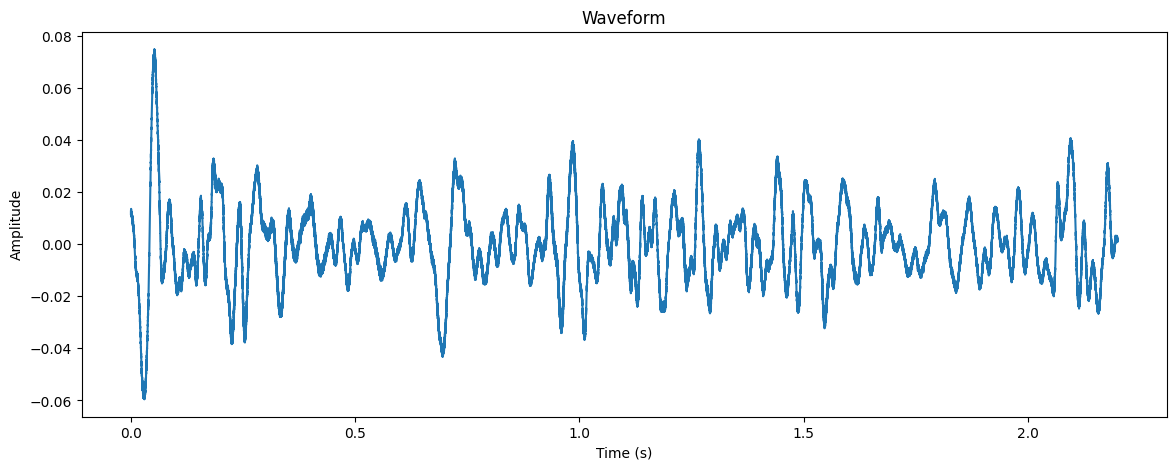

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate the time axis
time = np.arange(len(sample_audio)) / sr
# Plot the waveform
plt.figure(figsize=(14, 5))
plt.plot(time, sample_audio)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.show()


## Make a spectrogram form of the Audio

> In this section, "power_to_db" function changes the power to dB scale

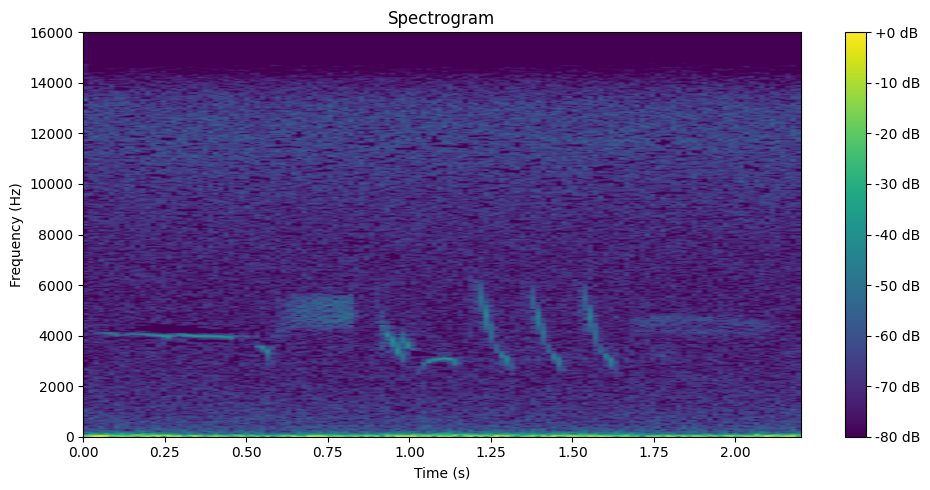

In [17]:
from torchaudio.transforms import Spectrogram

spectrogram_conversion= Spectrogram(n_fft=1024)
spectrogram=spectrogram_conversion(sample_tensor[0])
spectrogram_db = librosa.power_to_db(spectrogram.squeeze().numpy(), ref=np.max)

# Plot the spectrogram
plt.figure(figsize=(10, 5))
plt.imshow(spectrogram_db, aspect='auto', origin='lower', extent=[0, len(sample_audio)/sr, 0, sr/2])
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

# Step 7: Evaluate the Trained Model
## Part A: Evaluation with the whole test samples

In [41]:
#trainer.test(model=model,datamodule=dm)
trainer.test(model=model,dataloaders=test_loader,ckpt_path="best")

Restoring states from the checkpoint path at /workspace/notebooks/tutorials/additional_tutorials/lightning_logs/version_1/checkpoints/epoch=1-step=898.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /workspace/notebooks/tutorials/additional_tutorials/lightning_logs/version_1/checkpoints/epoch=1-step=898.ckpt


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  test/BCEWithLogitsLoss   │    0.12883560359477997    │
│          test/F1          │            0.0            │
│  test/MulticlassAccuracy  │            0.0            │
└───────────────────────────┴───────────────────────────┘

[{'test/BCEWithLogitsLoss': 0.12883560359477997,
  'test/MulticlassAccuracy': 0.0,
  'test/F1': 0.0}]

## Part B: Finding the e-Bird codes for a single test sample in multilabel Task 

### PartB_1) Selecting a single sample of test_dataloader

> There are two ways for selecting a single sample from your test dataset, the first one is mentioned in step 5 which takes a row audio file, then you need to change its format to spectrogram. We bring the second way here which takes a single sample from dataloader, that is already a spectrogram.

In [42]:
import torch
# Load the trained model
model.eval()  # Set the model to evaluation mode
test_loader = dm.test_dataloader()
batch2 = next(iter(test_loader))
# Extract audio data from the batch
audiox = batch2["input_values"][0]  # Assuming the first sample in the batch
label = batch2["labels"][0]
audiox=audiox.unsqueeze(0)
print("Original audio shape:", audiox.shape)
print("Label shape:", label.shape)
print("label",label)
# Pass the spectrogram data through the model for prediction
with torch.no_grad():
    output = model(audiox)
print(output.shape,output)

Original audio shape: torch.Size([1, 1, 128, 1024])
Label shape: torch.Size([21])
label tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.], dtype=torch.float16)
torch.Size([1, 21]) tensor([[-4.0198, -2.6912, -3.5123, -3.5861, -3.2109, -3.5147, -2.1558, -3.3631,
         -3.6766, -3.8974, -3.3391, -2.4104, -2.3517, -2.3697, -3.0240, -3.2846,
         -2.7495, -2.8863, -2.5903, -2.4734, -2.9784]])


### PartB_2) Prediction of the single sample's labels

In [43]:
# Interpret the model's prediction
# This depends on how your model's prediction method is implemented
# It could be returning class indices, probabilities, or even class labels directly
import torch

# Your tensor of logits
logits_tensor = output

# Apply sigmoid to convert logits to probabilities for each class
probabilities = torch.sigmoid(logits_tensor)
print(probabilities)
# Define a threshold (e.g., 0.5) to determine positive labels
threshold = 0.1

# Get the predicted labels based on the threshold

predicted_labels = (probabilities > threshold).nonzero().squeeze()

# Print the predicted labels
print("Predicted Labels:", predicted_labels.tolist())
label_indices = [label_set.item() for label_set in predicted_labels]

print("label_indices",label_indices)  

tensor([[0.0176, 0.0635, 0.0290, 0.0270, 0.0388, 0.0289, 0.1038, 0.0335, 0.0247,
         0.0199, 0.0343, 0.0824, 0.0869, 0.0855, 0.0464, 0.0361, 0.0601, 0.0528,
         0.0698, 0.0777, 0.0484]])
Predicted Labels: [0, 6]
label_indices [0, 6]


### PartB_3) Mapping of the single sample's labels to e-Birds Codes

In [44]:
import json
from typing import Dict

def get_label_to_category_mapping_from_metadata(
    file_path: str, task: str
) -> Dict[int, str]:
    """
    Reads a JSON file and extracts the mapping of labels to eBird codes.

    The function expects the JSON structure to be in a specific format, where the mapping
    is a list of names located under the keys 'features' -> 'labels' -> 'names'.
    The index in the list corresponds to the label, and the value at that index is the eBird code.

    Args:
    - file_path (str): The path to the JSON file containing the label to eBird code mapping.
    - task (str): The type of task for which to get the mapping. Expected values are "multiclass" or "multilabel".

    Returns:
    - Dict[int, str]: A dictionary where each key is a label (integer) and the corresponding value is the eBird code.

    Raises:
    - FileNotFoundError: If the file at `file_path` does not exist.
    - json.JSONDecodeError: If the file is not a valid JSON.
    - KeyError: If the expected keys ('features', 'labels', 'names') are not found in the JSON structure.
    """

    # Open the file and read the JSON data
    with open(file_path, "r") as file:
        dataset_info = json.load(file)

    # Extract the list of eBird codes from the loaded JSON structure.
    # Note: This assumes a specific structure of the JSON data.
    # If the structure is different, this line will raise a KeyError.
    if task == "multiclass":
        ebird_codes_list = dataset_info["features"]["labels"]["names"]
    elif task == "multilabel":
        ebird_codes_list = dataset_info["features"]["labels"]["feature"]["names"]
    else:
        # If the task is not recognized (not multiclass or multilabel), raise an error.
        raise NotImplementedError(
            f"Only the multiclass and multilabel tasks are implemented, not task {task}."
        )

    # Create a dictionary mapping each label (index) to the corresponding eBird code.
    mapping = {label: ebird_code for label, ebird_code in enumerate(ebird_codes_list)}

    return mapping

mapping = get_label_to_category_mapping_from_metadata(
    file_path='../../data_birdset/HSN/HSN_processed_42_1020340cef2a3604/train/dataset_info.json',
    task='multilabel'
)
print(mapping)

{0: 'gcrfin', 1: 'whcspa', 2: 'amepip', 3: 'sposan', 4: 'rocwre', 5: 'brebla', 6: 'daejun', 7: 'foxspa', 8: 'clanut', 9: 'moublu', 10: 'casfin', 11: 'mallar3', 12: 'herthr', 13: 'amerob', 14: 'yerwar', 15: 'yelwar', 16: 'dusfly', 17: 'mouchi', 18: 'orcwar', 19: 'warvir', 20: 'norfli'}


### PartB_4) Convert Prediction outputs to Class Label Names

In [45]:
predicted_class_names = [mapping[idx] for idx in label_indices]
print (predicted_class_names)
label = label.to(torch.int)
print (label)
real_class_names = [mapping[idx.item()] for idx in label if idx.item() != 0]
# Print the predicted class names
print("Real Class Names:", real_class_names)
print("Predicted Class Names:", predicted_class_names) 


['gcrfin', 'daejun']
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)
Real Class Names: ['whcspa']
Predicted Class Names: ['gcrfin', 'daejun']
